In [10]:
(asdf:load-system :imago/jupyter)
(asdf:load-system :diff-boundary-corrfn)
(asdf:load-system :numpy-file-format)

T

T

T

In [27]:
;; Create a function which sums values of 6 random bell-shaped curves
(defparameter *field*
  (diff-boundary-corrfn/math:gaussian-field
    (diff-boundary-corrfn/math:random-gaussians 6)))

*FIELD*

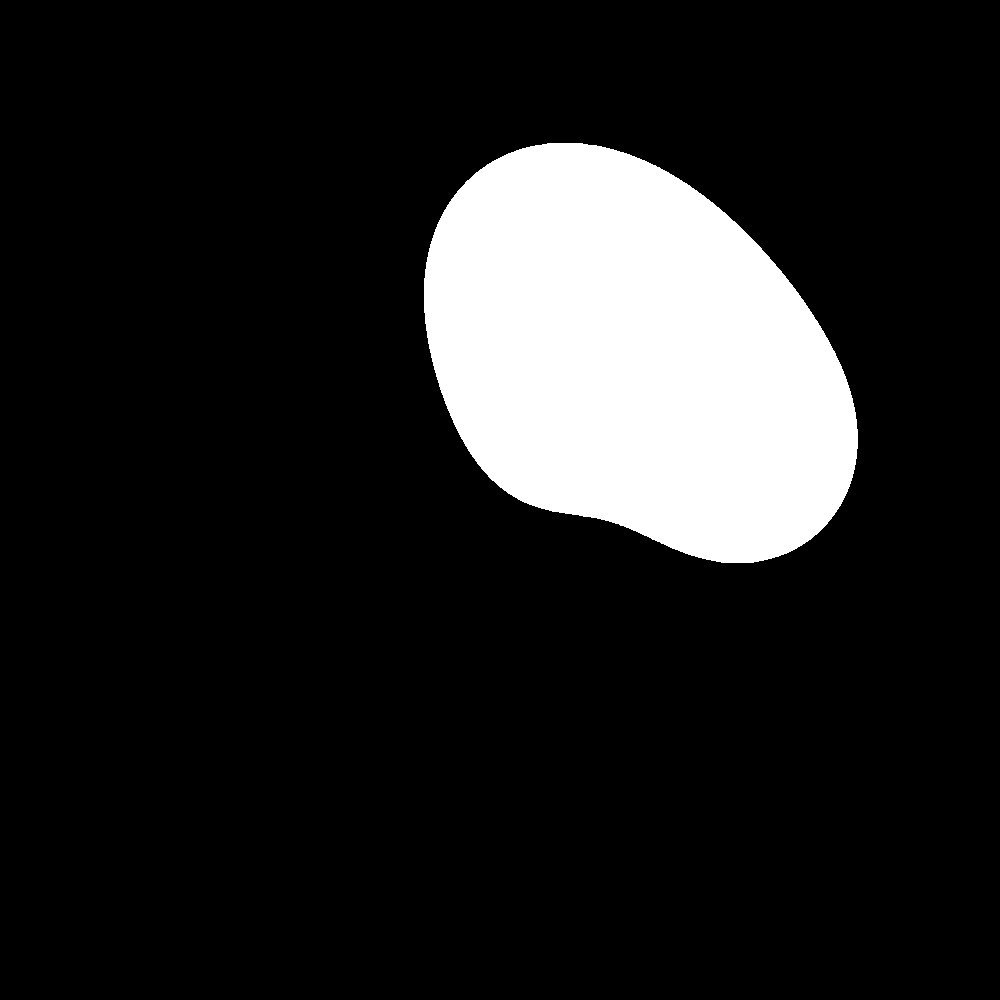

In [28]:
;; Evaluate it at points in uniform 3000x3000 grid and save an image
(let ((image (imago:make-binary-image-from-pixels
               (let ((descr (diff-boundary-corrfn:discretize-field 3000 *field*)))
                 (aops:vectorize* 'bit (descr) (if (> descr 5.0) 1 0))))))
  (imago:write-image image "/jails/julia/home/vasily/field.pbm")
  (imago-jupyter:show-image
    (imago:resize image 1000 1000)))

In [29]:
;; Calculate surface-surface function in a half-circle with radius R=0.1
;; Probably we need to disable division by zero trap because F_{ss} is ill-defined.
(defparameter *ss*
  (sb-int:with-float-traps-masked
    (:divide-by-zero)
    (let ((cl-optim:*ε* 1d-4)
          (interface (diff-boundary-corrfn:interface *field* 5d0)))
      (diff-boundary-corrfn:surface-surface-at-dist interface 1d-1 250))))

*SS*

In [30]:
;; Save results as a numpy array
(numpy-file-format:store-array
  (let ((ss (remove-if (lambda (x) (> (car x) 50)) *ss*)))
    (make-array (list (length ss) 3) :element-type 'double-float :initial-contents ss))
  "/jails/julia/home/vasily/ss-precise.npy")

NIL